In [225]:
# Minimal setup for Kaggle GPU
import os, random
import numpy as np
import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset
from pathlib import Path

SEED = 42

def set_seed(seed: int = SEED):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    # Keep cuDNN deterministic for reproducibility
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    # Helps determinism in CUDA matmul paths
    os.environ["CUBLAS_WORKSPACE_CONFIG"] = ":4096:8"

set_seed()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device: {device}")
print(f"PyTorch: {torch.__version__}")
if device.type == "cuda":
    print(f"CUDA: {torch.version.cuda}")
    print(f"cuDNN: {torch.backends.cudnn.version()}")
    print(f"GPU: {torch.cuda.get_device_name(0)}")


Device: cuda
PyTorch: 2.6.0+cu124
CUDA: 12.4
cuDNN: 90300
GPU: Tesla T4


In [226]:
import kagglehub
import os

# Download dataset from Kaggle
path = kagglehub.dataset_download("kinggleliu/hyperspectral-image-classification-data-collection")

print(" Dataset download path:", path)

# Verify files exist
if os.path.exists(path):
    print("\nDataset folder found!\n")
    for root, dirs, files in os.walk(path):
        for f in files:
            print(os.path.join(root, f))
else:
    print("\nDataset not found!")


 Dataset download path: /kaggle/input/hyperspectral-image-classification-data-collection

Dataset folder found!

/kaggle/input/hyperspectral-image-classification-data-collection/datasets/HyRANK/Loukia_gt_out68.mat
/kaggle/input/hyperspectral-image-classification-data-collection/datasets/HyRANK/Dioni_gt.mat
/kaggle/input/hyperspectral-image-classification-data-collection/datasets/HyRANK/Loukia.mat
/kaggle/input/hyperspectral-image-classification-data-collection/datasets/HyRANK/Loukia_gt.mat
/kaggle/input/hyperspectral-image-classification-data-collection/datasets/HyRANK/Dioni.mat
/kaggle/input/hyperspectral-image-classification-data-collection/datasets/pu/paviaC.mat
/kaggle/input/hyperspectral-image-classification-data-collection/datasets/pu/paviaC_7gt.mat
/kaggle/input/hyperspectral-image-classification-data-collection/datasets/pu/paviaU.mat
/kaggle/input/hyperspectral-image-classification-data-collection/datasets/pu/paviaU_7gt.mat
/kaggle/input/hyperspectral-image-classification-data-

In [227]:
import scipy.io as sio
import numpy as np

# Paths
data_path = "/kaggle/input/hyperspectral-image-classification-data-collection/datasets/ip/Indian_pines_corrected.mat"
gt_path   = "/kaggle/input/hyperspectral-image-classification-data-collection/datasets/ip/Indian_pines_gt.mat"

# Load .mat files
data_mat = sio.loadmat(data_path)
gt_mat   = sio.loadmat(gt_path)

# Extract arrays
X = data_mat["indian_pines_corrected"]   # shape (145, 145, 200)
y = gt_mat["indian_pines_gt"]            # shape (145, 145)

print("== Indian Pines loaded ==\n")
print(f"X shape: {X.shape} |  dtype: {X.dtype}")
print(f"y shape: {y.shape}      |  unique labels: {np.unique(y)}")


== Indian Pines loaded ==

X shape: (145, 145, 200) |  dtype: uint16
y shape: (145, 145)      |  unique labels: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16]


== Indian Pines Dataset Summary ==
dataset      : Indian Pines
X_shape      : (145, 145, 200)
X_dtype      : uint16
num_bands    : 200
y_shape      : (145, 145)
num_classes  : 16
unique_labels: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16]
class_distribution: {'3': 830, '15': 386, '11': 2455, '12': 593, '5': 483, '10': 972, '14': 1265, '16': 93, '2': 1428, '4': 237, '8': 478, '6': 730, '9': 20, '1': 46, '7': 28, '13': 205}


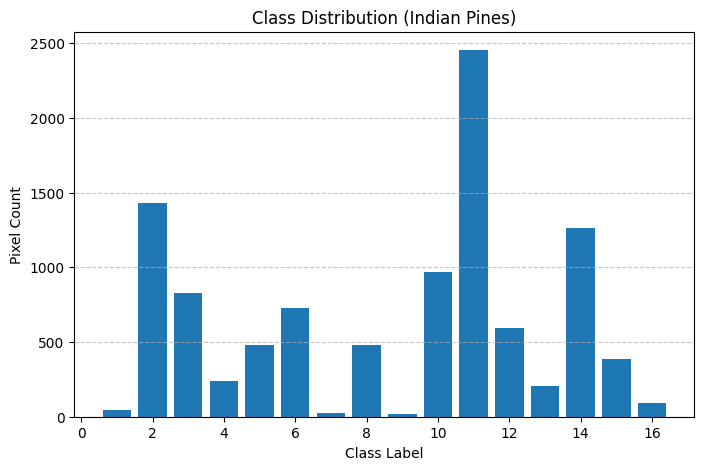


Dataset summary saved to indian_pines_summary.json


In [228]:
import json
import matplotlib.pyplot as plt
from collections import Counter

# Dataset summary
summary = {
    "dataset      ": "Indian Pines",
    "X_shape      ": X.shape,
    "X_dtype      ": str(X.dtype),
    "num_bands    ": X.shape[2],
    "y_shape      ": y.shape,
    "num_classes  ": int(y.max()),
    "unique_labels": [int(i) for i in np.unique(y)]
}

# Count pixels per class (excluding background 0)
labels_flat = y.flatten()
class_counts = Counter(labels_flat[labels_flat > 0])
summary["class_distribution"] = {str(k): int(v) for k, v in class_counts.items()}

# Print summary
print("== Indian Pines Dataset Summary ==")
for k, v in summary.items():
    print(f"{k}: {v}")

# Plot histogram
plt.figure(figsize=(8,5))
plt.bar(class_counts.keys(), class_counts.values())
plt.title("Class Distribution (Indian Pines)")
plt.xlabel("Class Label")
plt.ylabel("Pixel Count")
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()

# Save to JSON
save_path = "indian_pines_summary.json"
with open(save_path, "w") as f:
    json.dump(summary, f, indent=4)

print(f"\nDataset summary saved to {save_path}")


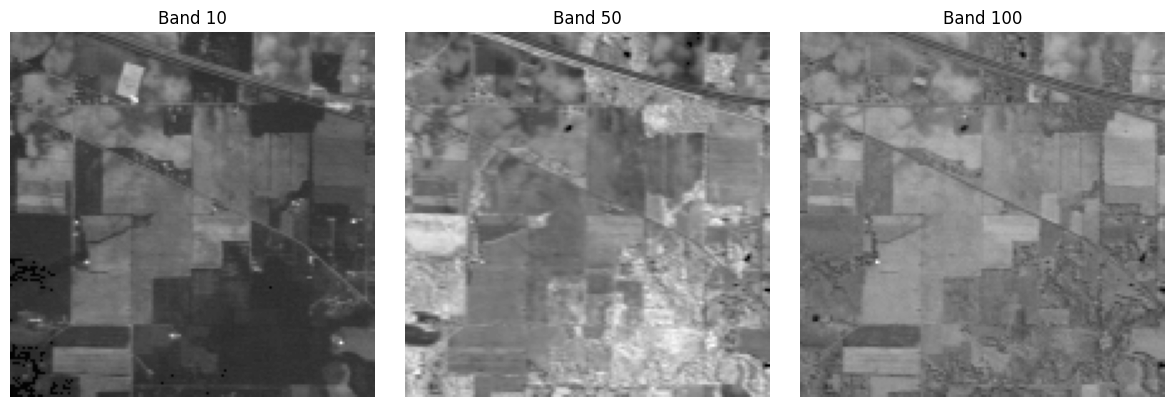

In [229]:
import matplotlib.pyplot as plt

# Pick 3 bands to visualize
bands_to_show = [10, 50, 100]  # I can change these indices (0–199)

plt.figure(figsize=(12,4))
for i, b in enumerate(bands_to_show):
    plt.subplot(1, 3, i+1)
    plt.imshow(X[:,:,b], cmap="gray")
    plt.title(f"Band {b}")
    plt.axis("off")

plt.tight_layout()
plt.show()


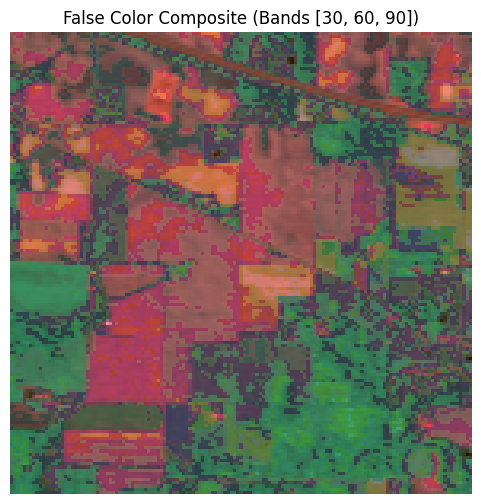

In [230]:
# False-color RGB visualization using 3 selected bands
rgb_bands = [30, 60, 90]  # you can adjust these
rgb_image = np.stack([X[:, :, b] for b in rgb_bands], axis=-1)

# Normalize for display (0–1 range)
rgb_norm = (rgb_image - rgb_image.min()) / (rgb_image.max() - rgb_image.min())

plt.figure(figsize=(6,6))
plt.imshow(rgb_norm)
plt.title(f"False Color Composite (Bands {rgb_bands})")
plt.axis("off")
plt.show()


In [231]:
# === Patch Extraction and Train/Val/Test Split (60/20/20) ===

import numpy as np
from sklearn.model_selection import train_test_split

def create_patches(X, y, patch_size=15, remove_background=True):
    pad = patch_size // 2
    X_pad = np.pad(X, ((pad, pad), (pad, pad), (0, 0)), mode='constant')
    y_pad = np.pad(y, ((pad, pad), (pad, pad)), mode='constant')

    X_patches, y_patches = [], []
    for i in range(pad, X.shape[0] + pad):
        for j in range(pad, X.shape[1] + pad):
            label = y_pad[i, j]
            if remove_background and label == 0:
                continue
            patch = X_pad[i - pad:i + pad + 1, j - pad:j + pad + 1, :]
            X_patches.append(patch)
            y_patches.append(label - 1)  # shift labels to 0-based

    return np.array(X_patches), np.array(y_patches)

# extract patches
patch_size = 15
X_patches, y_patches = create_patches(X, y, patch_size=patch_size)

# split into 60/20/20
X_train, X_tmp, y_train, y_tmp = train_test_split(
    X_patches, y_patches, test_size=0.4, stratify=y_patches, random_state=42
)
X_val, X_test, y_val, y_test = train_test_split(
    X_tmp, y_tmp, test_size=0.5, stratify=y_tmp, random_state=42
)

print("== Patch Extraction Complete ==")
print(f"\nPatch size : {patch_size}x{patch_size}x{X.shape[2]}")
print(f"Train      : {X_train.shape[0]} samples | {y_train.shape[0]} labels")
print(f"Val        : {X_val.shape[0]} samples | {y_val.shape[0]} labels")
print(f"Test       : {X_test.shape[0]} samples | {y_test.shape[0]} labels")


== Patch Extraction Complete ==

Patch size : 15x15x200
Train      : 6149 samples | 6149 labels
Val        : 2050 samples | 2050 labels
Test       : 2050 samples | 2050 labels


In [232]:
# === PyTorch Dataset and DataLoader ===

import torch
from torch.utils.data import Dataset, DataLoader

class HyperspectralDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.from_numpy(X).float()
        self.y = torch.from_numpy(y).long()

        # reshape to (C, D, H, W) for 3D CNN
        # here: (bands, patch_size, patch_size)
        self.X = self.X.permute(0, 3, 1, 2)  # (N, C, H, W)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

# create datasets
train_dataset = HyperspectralDataset(X_train, y_train)
val_dataset   = HyperspectralDataset(X_val, y_val)
test_dataset  = HyperspectralDataset(X_test, y_test)

# create dataloaders
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader  = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print("== DataLoaders Ready ==")
print(f"\nTrain batches : {len(train_loader)}")
print(f"Val batches   : {len(val_loader)}")
print(f"Test batches  : {len(test_loader)}")


== DataLoaders Ready ==

Train batches : 97
Val batches   : 33
Test batches  : 33


In [233]:
# === Hybrid 3D CNN + Transformer Model (Improved) ===
import torch.nn as nn
import torch

class Hybrid3DCNNTransformer(nn.Module):
    def __init__(self, num_classes, embed_dim=128, num_heads=4, num_layers=3, dropout=0.3):
        super(Hybrid3DCNNTransformer, self).__init__()

        # 3D CNN feature extractor (added extra block with more channels)
        self.cnn3d = nn.Sequential(
            nn.Conv3d(1, 8, kernel_size=(3,3,7), padding=(1,1,3)),
            nn.BatchNorm3d(8),
            nn.ReLU(),
            nn.MaxPool3d((1,1,2)),

            nn.Conv3d(8, 16, kernel_size=(3,3,5), padding=(1,1,2)),
            nn.BatchNorm3d(16),
            nn.ReLU(),
            nn.MaxPool3d((1,1,2)),

            nn.Conv3d(16, 32, kernel_size=(3,3,3), padding=1),
            nn.BatchNorm3d(32),
            nn.ReLU(),
            nn.MaxPool3d((2,2,2))  # downsample more
        )

        # adaptive pooling for stable feature size
        self.global_pool = nn.AdaptiveAvgPool3d((1, 1, 1))   # → (B, 32, 1,1,1)

        # projection to transformer embedding
        self.proj_cnn = nn.Linear(32, embed_dim)

        # transformer encoder
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=embed_dim, nhead=num_heads, batch_first=True, dropout=dropout
        )
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)

        # dropout + layer norm + classifier
        self.norm = nn.LayerNorm(embed_dim)
        self.classifier = nn.Sequential(
            nn.Dropout(0.4),
            nn.Linear(embed_dim, num_classes)
        )

    def forward(self, x):
        # input shape: (B, C, H, W)
        x = x.unsqueeze(1)                 # (B, 1, C, H, W)
        cnn_feat = self.cnn3d(x)           # (B, 32, C’, H’, W’)

        # global pooling → (B, 32)
        cnn_feat = self.global_pool(cnn_feat).view(x.size(0), 32)

        # project to transformer embedding
        x_proj = self.proj_cnn(cnn_feat).unsqueeze(1)   # (B, 1, embed_dim)

        # transformer encoder
        x_trans = self.transformer(x_proj)              # (B, 1, embed_dim)

        # norm + classification
        x_out = self.norm(x_trans[:, 0, :])             # (B, embed_dim)
        out = self.classifier(x_out)                    # (B, num_classes)
        return out




# instantiate improved model as teacher
num_classes = len(np.unique(y_patches))
model = Hybrid3DCNNTransformer(num_classes=num_classes).to(device)
print("== Improved Hybrid 3D CNN + Transformer Model Ready ==")






# # instantiate improved model
# num_classes = len(np.unique(y_patches))
# model = Hybrid3DCNNTransformer(num_classes=num_classes)
# print("== Improved Hybrid 3D CNN + Transformer Model Ready ==")


== Improved Hybrid 3D CNN + Transformer Model Ready ==


In [234]:
# === Training Setup ===

import torch.optim as optim

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-5)

# training loop
def train_model(model, train_loader, val_loader, criterion, optimizer, epochs=20):
    for epoch in range(epochs):
        model.train()
        train_loss, correct, total = 0, 0, 0

        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)

            optimizer.zero_grad()
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            _, preds = outputs.max(1)
            correct += preds.eq(y_batch).sum().item()
            total += y_batch.size(0)

        train_acc = 100. * correct / total
        val_acc, val_loss = evaluate(model, val_loader, criterion)

        print(f"Epoch [{epoch+1}/{epochs}] "
              f"Train Loss: {train_loss/len(train_loader):.4f} | "
              f"Train Acc: {train_acc:.2f}% | "
              f"Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.2f}%")

# validation helper
def evaluate(model, loader, criterion):
    model.eval()
    loss, correct, total = 0, 0, 0
    with torch.no_grad():
        for X_batch, y_batch in loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            outputs = model(X_batch)
            loss += criterion(outputs, y_batch).item()
            _, preds = outputs.max(1)
            correct += preds.eq(y_batch).sum().item()
            total += y_batch.size(0)

    acc = 100. * correct / total
    return acc, loss / len(loader)

print("== Training setup completed successfully ==")

== Training setup completed successfully ==


In [235]:
# === Training with Early Stopping & Scheduler ===
import copy

class EarlyStopping:
    def __init__(self, patience=5, min_delta=0, save_path="best_model_improved.pth"):
        self.patience = patience
        self.min_delta = min_delta
        self.best_loss = None
        self.counter = 0
        self.early_stop = False
        self.save_path = save_path
        self.best_model_wts = None

    def __call__(self, val_loss, model):
        if self.best_loss is None:
            self.best_loss = val_loss
            self.best_model_wts = copy.deepcopy(model.state_dict())
            torch.save(self.best_model_wts, self.save_path)

        elif val_loss > self.best_loss - self.min_delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_loss = val_loss
            self.counter = 0
            self.best_model_wts = copy.deepcopy(model.state_dict())
            torch.save(self.best_model_wts, self.save_path)


def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, epochs=50, patience=5, save_path="best_model_improved.pth"):
    early_stopping = EarlyStopping(patience=patience, save_path=save_path)
    for epoch in range(epochs):
        model.train()
        train_loss, correct, total = 0, 0, 0

        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)

            optimizer.zero_grad()
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            _, preds = outputs.max(1)
            correct += preds.eq(y_batch).sum().item()
            total += y_batch.size(0)

        train_acc = 100. * correct / total
        val_acc, val_loss = evaluate(model, val_loader, criterion)

        print(f"Epoch [{epoch+1}/{epochs}] "
              f"Train Loss: {train_loss/len(train_loader):.4f} | "
              f"Train Acc: {train_acc:.2f}% | "
              f"Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.2f}%")

        # scheduler update
        scheduler.step(val_loss)
        current_lr = scheduler.optimizer.param_groups[0]['lr']
        print(f"Current LR: {current_lr:.6f}")


        # check early stopping and save best model
        early_stopping(val_loss, model)
        if early_stopping.early_stop:
            print("Early stopping triggered.")
            break

    # load best model weights
    model.load_state_dict(torch.load(save_path))
    print(f"== Training finished. Best model saved at '{save_path}' ==")
    return model



print("== Successfully Executed ==")

== Successfully Executed ==


In [236]:
# === Run Training ===
epochs = 20
patience = 6
save_path = "best_model_improved.pth"

# optimizer with weight decay
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-5)

# learning rate scheduler (no verbose)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', patience=3, factor=0.5
)


print("Starting training...")
model = train_model(model, train_loader, val_loader, criterion, optimizer, scheduler,
                    epochs=epochs, patience=patience, save_path=save_path)
print("== Training complete and best model loaded ==")


Starting training...
Epoch [1/20] Train Loss: 2.3739 | Train Acc: 23.99% | Val Loss: 1.9124 | Val Acc: 38.78%
Current LR: 0.000100
Epoch [2/20] Train Loss: 1.9705 | Train Acc: 36.05% | Val Loss: 1.7246 | Val Acc: 41.95%
Current LR: 0.000100
Epoch [3/20] Train Loss: 1.7570 | Train Acc: 42.69% | Val Loss: 1.4801 | Val Acc: 48.59%
Current LR: 0.000100
Epoch [4/20] Train Loss: 1.6251 | Train Acc: 45.10% | Val Loss: 1.3639 | Val Acc: 52.29%
Current LR: 0.000100
Epoch [5/20] Train Loss: 1.5392 | Train Acc: 46.74% | Val Loss: 1.7489 | Val Acc: 43.27%
Current LR: 0.000100
Epoch [6/20] Train Loss: 1.4198 | Train Acc: 50.66% | Val Loss: 1.2542 | Val Acc: 54.20%
Current LR: 0.000100
Epoch [7/20] Train Loss: 1.3632 | Train Acc: 51.83% | Val Loss: 1.6335 | Val Acc: 44.44%
Current LR: 0.000100
Epoch [8/20] Train Loss: 1.3019 | Train Acc: 53.94% | Val Loss: 1.1333 | Val Acc: 58.49%
Current LR: 0.000100
Epoch [9/20] Train Loss: 1.2552 | Train Acc: 55.70% | Val Loss: 1.0552 | Val Acc: 60.39%
Current LR


Test Loss: 0.6676
Test Accuracy: 75.27%

Classification Report:

              precision    recall  f1-score   support

           0       0.57      0.44      0.50         9
           1       0.66      0.69      0.68       285
           2       0.53      0.73      0.62       166
           3       1.00      0.27      0.43        48
           4       0.89      0.75      0.82        97
           5       0.79      0.99      0.88       146
           6       0.00      0.00      0.00         6
           7       0.97      0.96      0.96        95
           8       1.00      0.25      0.40         4
           9       0.56      0.85      0.68       195
          10       0.90      0.60      0.72       491
          11       0.61      0.63      0.62       118
          12       0.61      0.73      0.67        41
          13       0.96      0.98      0.97       253
          14       0.93      0.91      0.92        77
          15       0.88      0.79      0.83        19

    accuracy  

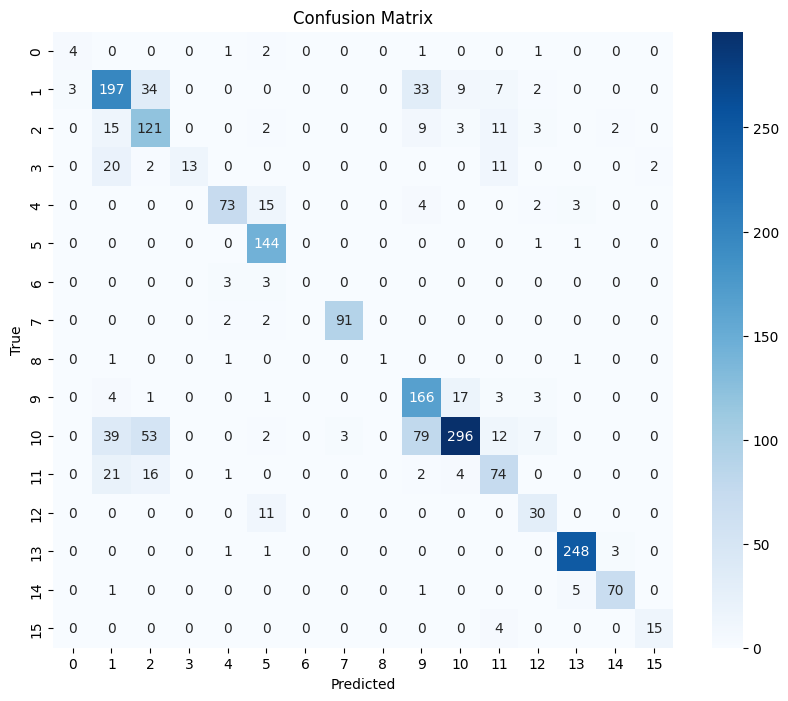

In [237]:
# ========================
# Testing / Evaluation Cell
# ========================

import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load your saved best model
model_path = "best_model_improved.pth"
model.load_state_dict(torch.load(model_path, map_location=device))
model.to(device)
model.eval()  # set model to evaluation mode

# Prepare test/validation data loader
test_loader = DataLoader(
    test_dataset,  # ensure 'test_dataset' is already defined
    batch_size=16,  # you can adjust batch size
    shuffle=False
)

all_preds = []
all_labels = []

criterion = nn.CrossEntropyLoss()

test_loss = 0.0

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        test_loss += loss.item() * inputs.size(0)
        
        preds = torch.argmax(outputs, dim=1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Calculate metrics
test_loss = test_loss / len(test_loader.dataset)
accuracy = accuracy_score(all_labels, all_preds)

print(f"\nTest Loss: {test_loss:.4f}")
print(f"Test Accuracy: {accuracy*100:.2f}%\n")
print("Classification Report:\n")
print(classification_report(all_labels, all_preds, zero_division=0))

# Confusion Matrix
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()


In [238]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# must exist from earlier cells:
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# num_classes = <int>

class StudentCNN(nn.Module):
    def __init__(self, num_classes: int, in_channels: int = 200):
        super().__init__()
        # use the in_channels argument properly (no hardcoding)
        self.conv1 = nn.Conv2d(in_channels, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2)
        self.gap = nn.AdaptiveAvgPool2d((1, 1))
        self.fc1 = nn.Linear(64, 128)
        self.fc2 = nn.Linear(128, num_classes)

        self._init_weights()

    def _init_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.zeros_(m.bias)
            elif isinstance(m, nn.Linear):
                nn.init.xavier_normal_(m.weight)
                if m.bias is not None:
                    nn.init.zeros_(m.bias)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        assert x.ndim == 4, f"Expected 4D input (B, C, H, W), got shape {tuple(x.shape)}"
        x = F.relu(self.conv1(x))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.gap(x)           # (B, 64, 1, 1)
        x = torch.flatten(x, 1)   # (B, 64)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)           # (B, num_classes)
        return x

# IMPORTANT: inputs are (B, 200, H, W) -> set in_channels=200
student_model = StudentCNN(num_classes=num_classes, in_channels=200).to(device)
print("StudentCNN initialized and on device:", next(student_model.parameters()).device)


StudentCNN initialized and on device: cuda:0


In [239]:
#Knowledge Distillation Loss
import torch.nn.functional as F

def distillation_loss(student_logits, teacher_logits, labels, T=4.0, alpha=0.7):
    """
    Knowledge Distillation Loss = alpha * KD_loss + (1 - alpha) * CE_loss
    - KD_loss: KL divergence between student and teacher soft predictions
    - CE_loss: Standard cross entropy with ground truth labels
    """
    kd_loss = F.kl_div(
        F.log_softmax(student_logits / T, dim=1),
        F.softmax(teacher_logits / T, dim=1),
        reduction="batchmean"
    ) * (T * T)

    ce_loss = F.cross_entropy(student_logits, labels)

    return alpha * kd_loss + (1 - alpha) * ce_loss


In [240]:
#KD training (auto-align student head to teacher classes before training)

optimizer = torch.optim.Adam(student_model.parameters(), lr=1e-3)
num_epochs = 20  # adjust if desired

student_model.train()
teacher_model = model  # teacher = pretrained Hybrid CNN+Transformer
teacher_model.eval()

# --- Align student head to teacher's number of classes (pre-KD) ---
with torch.no_grad():
    # grab one batch to infer teacher output dimension
    sample_inputs, _ = next(iter(train_loader))
    sample_inputs = sample_inputs.to(device)  # shape expected: (B, 200, H, W)
    teacher_sample_logits = teacher_model(sample_inputs)
    teacher_num_classes = teacher_sample_logits.size(1)

# if mismatch, replace student's final layer to match teacher
student_num_classes = student_model.fc2.out_features
if student_num_classes != teacher_num_classes:
    student_model.fc2 = nn.Linear(128, teacher_num_classes).to(device)
    # (re)init weights of the replaced layer
    nn.init.xavier_normal_(student_model.fc2.weight)
    if student_model.fc2.bias is not None:
        nn.init.zeros_(student_model.fc2.bias)

for epoch in range(num_epochs):
    total_loss = 0.0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)  # inputs: (B, 200, H, W)

        optimizer.zero_grad()

        # Forward: student
        student_logits = student_model(inputs)

        # Forward: teacher (no grad)
        with torch.no_grad():
            teacher_logits = teacher_model(inputs)

        # KD loss
        loss = distillation_loss(student_logits, teacher_logits, labels, T=4, alpha=0.7)

        loss.backward()
        optimizer.step()

        total_loss += loss.item() * inputs.size(0)

    epoch_loss = total_loss / len(train_loader.dataset)
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}")


Epoch 1/20, Loss: 1349.2299
Epoch 2/20, Loss: 5.0934
Epoch 3/20, Loss: 3.7109
Epoch 4/20, Loss: 3.1792
Epoch 5/20, Loss: 2.8861
Epoch 6/20, Loss: 2.6908
Epoch 7/20, Loss: 2.5562
Epoch 8/20, Loss: 2.5475
Epoch 9/20, Loss: 2.3213
Epoch 10/20, Loss: 2.2913
Epoch 11/20, Loss: 2.1946
Epoch 12/20, Loss: 2.1393
Epoch 13/20, Loss: 2.0969
Epoch 14/20, Loss: 2.0533
Epoch 15/20, Loss: 2.0168
Epoch 16/20, Loss: 1.9885
Epoch 17/20, Loss: 1.9886
Epoch 18/20, Loss: 1.9457
Epoch 19/20, Loss: 1.9301
Epoch 20/20, Loss: 1.9071


In [241]:
#Pruning the student model

import torch.nn.utils.prune as prune

# Create a copy of student model for pruning
pruned_student = StudentCNN(num_classes=student_model.fc2.out_features,
                            in_channels=200).to(device)

# load the trained weights from student into pruned model
pruned_student.load_state_dict(student_model.state_dict())

# Apply structured pruning (L1 unstructured by default)
for module_name, module in pruned_student.named_modules():
    if isinstance(module, nn.Conv2d) or isinstance(module, nn.Linear):
        prune.l1_unstructured(module, name="weight", amount=0.3)  # 30% pruning

print("Pruning applied to student model.")


Pruning applied to student model.


In [242]:
#clean evaluation function to test accuracy and loss

def evaluate_model(model, data_loader, device):
    model.eval()
    total_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in data_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = F.cross_entropy(outputs, labels)

            total_loss += loss.item() * inputs.size(0)
            preds = outputs.argmax(dim=1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

    avg_loss = total_loss / total
    accuracy = correct / total * 100
    return avg_loss, accuracy
print(f" == Load Successfully. Run the next Cell. == ")

 == Load Successfully. Run the next Cell. == 


In [243]:
#Compare Teacher and Student

import io, time, copy
import torch.nn.utils.prune as prune

def count_params(model, trainable_only=False):
    if trainable_only:
        return sum(p.numel() for p in model.parameters() if p.requires_grad)
    return sum(p.numel() for p in model.parameters())

def export_size_mb(model):
    m = copy.deepcopy(model).cpu()
    for module in m.modules():
        if isinstance(module, (nn.Conv2d, nn.Linear)) and hasattr(module, "weight_mask"):
            try:
                prune.remove(module, "weight")
            except Exception:
                pass
    buffer = io.BytesIO()
    torch.save(m.state_dict(), buffer)
    return len(buffer.getvalue()) / (1024 * 1024)

def get_sparsity(model):
    zeros = 0
    total = 0
    for module in model.modules():
        if isinstance(module, (nn.Conv2d, nn.Linear)):
            if hasattr(module, "weight_mask"):
                mask = module.weight_mask.detach()
                zeros += (mask == 0).sum().item()
                total += mask.numel()
            else:
                w = module.weight.detach()
                zeros += (w == 0).sum().item()
                total += w.numel()
    return 100.0 * zeros / total if total > 0 else 0.0

@torch.no_grad()
def measure_latency(model, example_inputs, runs=50, warmup=10, device=None):
    if device is None:
        device = next(model.parameters()).device
    model.eval()
    example_inputs = example_inputs.to(device)
    for _ in range(warmup):
        _ = model(example_inputs)
    if device.type == "cuda":
        torch.cuda.synchronize()
    t0 = time.time()
    for _ in range(runs):
        _ = model(example_inputs)
    if device.type == "cuda":
        torch.cuda.synchronize()
    elapsed = time.time() - t0
    avg_per_run = elapsed / runs
    bsz = example_inputs.size(0)
    per_sample = avg_per_run / bsz
    return avg_per_run * 1000.0, per_sample * 1000.0


In [244]:
# Utilities: parameter counts, export size, sparsity, latency
import io, time, copy
import torch
import torch.nn as nn
import torch.nn.utils.prune as prune

def count_params(model, trainable_only=False):
    if trainable_only:
        return sum(p.numel() for p in model.parameters() if p.requires_grad)
    return sum(p.numel() for p in model.parameters())

def export_size_mb(model):
    # clone and remove pruning reparams for a true exportable size
    m = copy.deepcopy(model).cpu()
    for module in m.modules():
        if isinstance(module, (nn.Conv2d, nn.Linear)) and hasattr(module, "weight_mask"):
            try:
                prune.remove(module, "weight")
            except Exception:
                pass
    buffer = io.BytesIO()
    torch.save(m.state_dict(), buffer)
    return len(buffer.getvalue()) / (1024 * 1024)

def get_sparsity(model):
    zeros = 0
    total = 0
    for module in model.modules():
        if isinstance(module, (nn.Conv2d, nn.Linear)):
            if hasattr(module, "weight_mask"):
                mask = module.weight_mask.detach()
                zeros += (mask == 0).sum().item()
                total += mask.numel()
            else:
                w = module.weight.detach()
                zeros += (w == 0).sum().item()
                total += w.numel()
    return 100.0 * zeros / total if total > 0 else 0.0

@torch.no_grad()
def measure_latency(model, example_inputs, runs=50, warmup=10, device=None):
    if device is None:
        device = next(model.parameters()).device
    model.eval()
    example_inputs = example_inputs.to(device)
    # warmup
    for _ in range(warmup):
        _ = model(example_inputs)
    if device.type == "cuda":
        torch.cuda.synchronize()
    t0 = time.time()
    for _ in range(runs):
        _ = model(example_inputs)
    if device.type == "cuda":
        torch.cuda.synchronize()
    elapsed = time.time() - t0
    avg_per_run = elapsed / runs
    bsz = example_inputs.size(0)
    per_sample = avg_per_run / bsz
    return avg_per_run * 1000.0, per_sample * 1000.0  # ms


print(f" == Load Successfully. Run the next Cell. == ")


 == Load Successfully. Run the next Cell. == 


In [245]:
#Detailed comparison table (accuracy, params, size, sparsity, latency)
import pandas as pd

teacher_model = teacher_model.to(device).eval()
pruned_student = pruned_student.to(device).eval()

# Evaluate both models
teacher_loss, teacher_acc = evaluate_model(teacher_model, test_loader, device)
pruned_loss, pruned_acc = evaluate_model(pruned_student, test_loader, device)

# One batch for latency measurement
sample_inputs, _ = next(iter(test_loader))
sample_inputs = sample_inputs.to(device)

rows = []
for name, m, (loss, acc) in [
    ("Teacher", teacher_model, (teacher_loss, teacher_acc)),
    ("Pruned Student", pruned_student, (pruned_loss, pruned_acc)),
]:
    params = count_params(m, trainable_only=False)
    trainable = count_params(m, trainable_only=False)
    size_mb = export_size_mb(m)
    sparsity = get_sparsity(m)
    batch_ms, sample_ms = measure_latency(m, sample_inputs, runs=50, warmup=10, device=device)
    rows.append({
        "Model": name,
        "Test Loss": round(loss, 4),
        "Test Acc (%)": round(acc, 2),
        "Params (M)": round(params / 1e6, 3),
        "Trainable (M)": round(trainable / 1e6, 3),
        "Export Size (MB)": round(size_mb, 2),
        "Sparsity (%)": round(sparsity, 2),
        "Latency / batch (ms)": round(batch_ms, 2),
        "Latency / sample (ms)": round(sample_ms, 4),
        "Batch size": sample_inputs.size(0),
    })

df = pd.DataFrame(rows)
print(df.to_string(index=False))


         Model  Test Loss  Test Acc (%)  Params (M)  Trainable (M)  Export Size (MB)  Sparsity (%)  Latency / batch (ms)  Latency / sample (ms)  Batch size
       Teacher     0.6676         75.27       1.806          1.806              6.91           0.0                 13.14                 0.8212          16
Pruned Student     3.4201         23.41       0.087          0.087              0.33          30.0                  0.74                 0.0465          16


=== Teacher Model Report ===
              precision    recall  f1-score   support

           0     0.5714    0.4444    0.5000         9
           1     0.6611    0.6912    0.6758       285
           2     0.5330    0.7289    0.6158       166
           3     1.0000    0.2708    0.4262        48
           4     0.8902    0.7526    0.8156        97
           5     0.7869    0.9863    0.8754       146
           6     0.0000    0.0000    0.0000         6
           7     0.9681    0.9579    0.9630        95
           8     1.0000    0.2500    0.4000         4
           9     0.5627    0.8513    0.6776       195
          10     0.8997    0.6029    0.7220       491
          11     0.6066    0.6271    0.6167       118
          12     0.6122    0.7317    0.6667        41
          13     0.9612    0.9802    0.9706       253
          14     0.9333    0.9091    0.9211        77
          15     0.8824    0.7895    0.8333        19

    accuracy                         0.7527      20

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classif

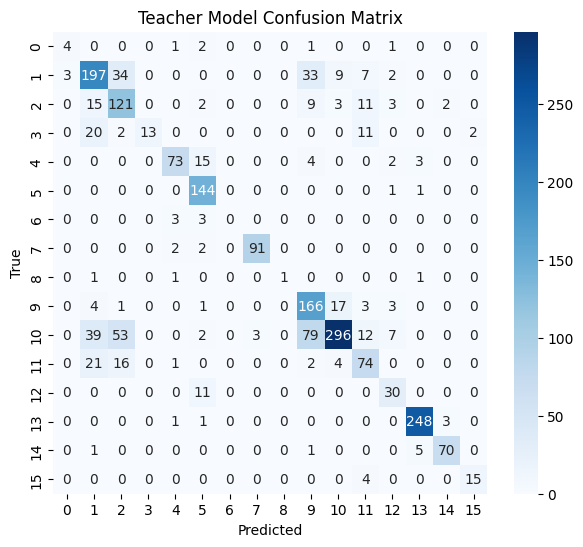

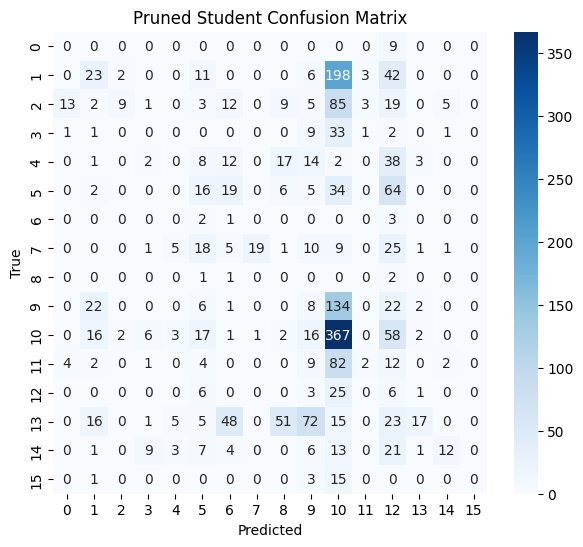

In [246]:
# === Reports + Confusion Matrices for Teacher and Pruned Student ===
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch

def get_all_preds(model, data_loader, device):
    model.eval()
    all_labels, all_preds = [], []
    with torch.no_grad():
        for inputs, labels in data_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            preds = outputs.argmax(dim=1)
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())
    return np.array(all_labels), np.array(all_preds)

def plot_conf_matrix(labels, preds, title, class_names=None):
    cm = confusion_matrix(labels, preds)
    plt.figure(figsize=(7,6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=class_names if class_names else np.arange(cm.shape[1]),
                yticklabels=class_names if class_names else np.arange(cm.shape[0]))
    plt.title(title)
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.show()

# Predictions
teacher_labels, teacher_preds = get_all_preds(teacher_model, test_loader, device)
pruned_labels, pruned_preds   = get_all_preds(pruned_student, test_loader, device)

# Reports
print("=== Teacher Model Report ===")
print(classification_report(teacher_labels, teacher_preds, digits=4))

print("\n=== Pruned Student Model Report ===")
print(classification_report(pruned_labels, pruned_preds, digits=4))

# Class names
try:
    class_names = test_loader.dataset.classes
except:
    class_names = None

# Confusion matrices
plot_conf_matrix(teacher_labels, teacher_preds, "Teacher Model Confusion Matrix", class_names)
plot_conf_matrix(pruned_labels, pruned_preds, "Pruned Student Confusion Matrix", class_names)


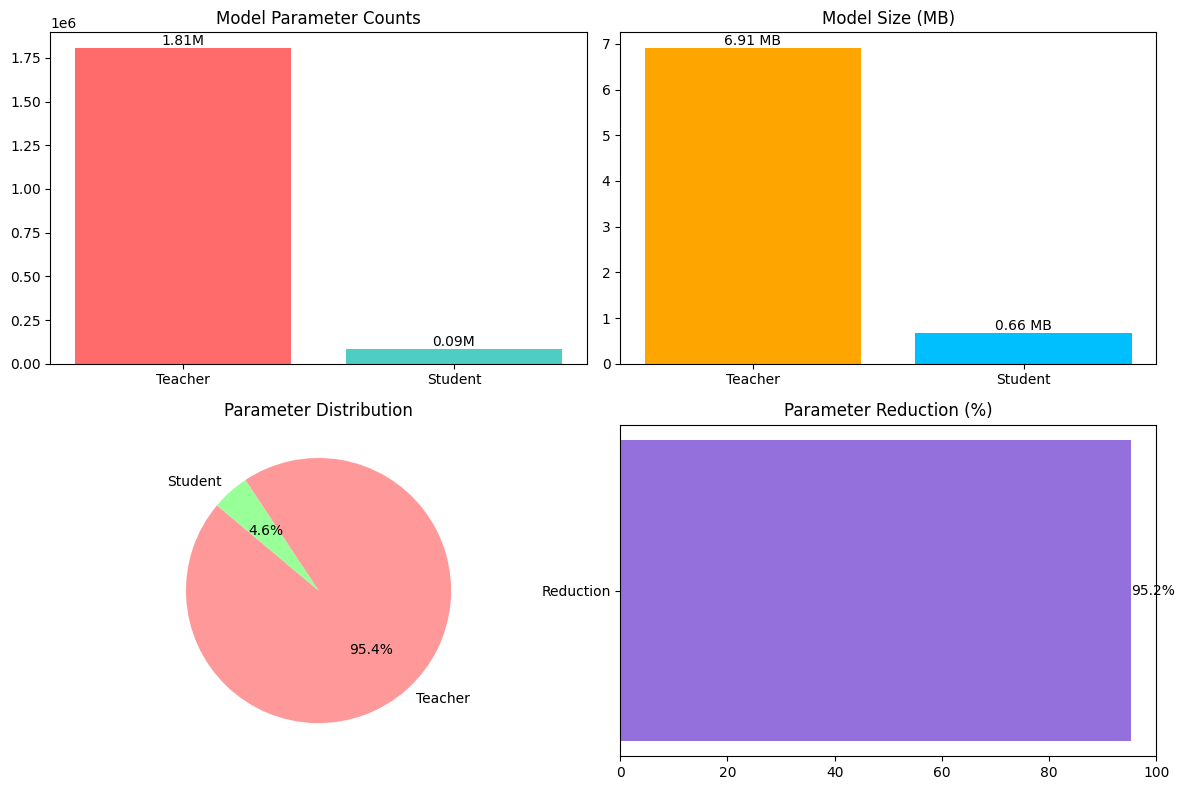

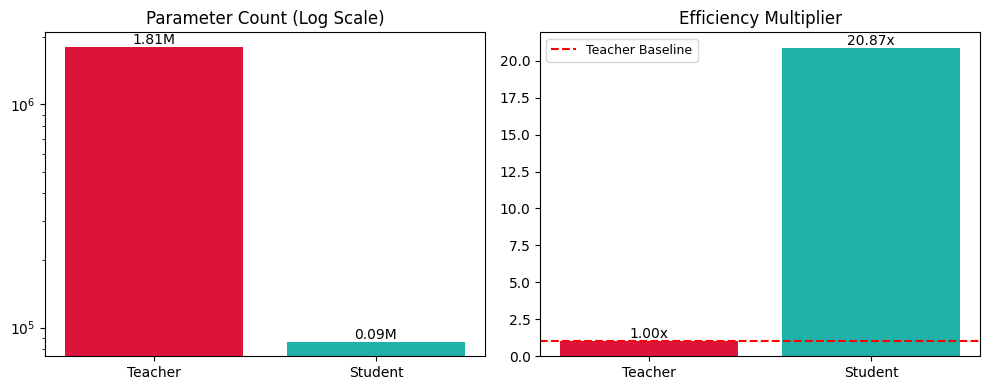

In [247]:
import torch
import matplotlib.pyplot as plt
import numpy as np
import os

# ===== Utility functions =====
def get_model_size(model):
    torch.save(model.state_dict(), "temp.pth")
    size_mb = os.path.getsize("temp.pth") / (1024 * 1024)
    os.remove("temp.pth")
    return size_mb

def count_parameters(model, trainable_only=False):
    if trainable_only:
        return sum(p.numel() for p in model.parameters() if p.requires_grad)
    return sum(p.numel() for p in model.parameters())

# ===== Teacher & Student Stats =====
teacher_params_total = count_parameters(teacher_model, trainable_only=False)
student_params_total = count_parameters(pruned_student, trainable_only=False)

teacher_size = get_model_size(teacher_model)
student_size = get_model_size(pruned_student)

# Safe division (avoid zero errors)
if teacher_params_total > 0 and student_params_total > 0:
    reduction = (1 - student_params_total / teacher_params_total) * 100
    efficiency = teacher_params_total / student_params_total
else:
    reduction, efficiency = 0, 1.0

# ===== Visualization =====
fig, axs = plt.subplots(2, 2, figsize=(12, 8))  # smaller than before

# --- Bar Chart: Parameters ---
axs[0,0].bar(["Teacher", "Student"], [teacher_params_total, student_params_total], 
             color=["#FF6B6B", "#4ECDC4"])
axs[0,0].set_title("Model Parameter Counts", fontsize=12)
for i, val in enumerate([teacher_params_total, student_params_total]):
    axs[0,0].text(i, val, f"{val/1e6:.2f}M", ha="center", va="bottom", fontsize=10)

# --- Bar Chart: Model Sizes ---
axs[0,1].bar(["Teacher", "Student"], [teacher_size, student_size], 
             color=["#FFA500", "#00BFFF"])
axs[0,1].set_title("Model Size (MB)", fontsize=12)
for i, val in enumerate([teacher_size, student_size]):
    axs[0,1].text(i, val, f"{val:.2f} MB", ha="center", va="bottom", fontsize=10)

# --- Pie Chart: Distribution ---
if teacher_params_total + student_params_total > 0:
    axs[1,0].pie([teacher_params_total, student_params_total], labels=["Teacher", "Student"],
                 autopct="%1.1f%%", colors=["#FF9999", "#99FF99"], startangle=140, textprops={'fontsize': 10})
else:
    axs[1,0].text(0.5, 0.5, "No parameters found", ha="center", va="center")
axs[1,0].set_title("Parameter Distribution", fontsize=12)

# --- Horizontal Bar: Reduction ---
axs[1,1].barh(["Reduction"], [reduction], color="#9370DB")
axs[1,1].set_xlim(0, 100)
axs[1,1].set_title("Parameter Reduction (%)", fontsize=12)
axs[1,1].text(reduction, 0, f"{reduction:.1f}%", va="center", ha="left", fontsize=10)

plt.tight_layout()
plt.savefig("model_comparison_basic_small.png", dpi=500)
plt.show()

# ===== Detailed Efficiency Plot =====
fig, axs = plt.subplots(1, 2, figsize=(10, 4))  # much smaller

# --- Log scale params ---
axs[0].bar(["Teacher", "Student"], 
           [max(1, teacher_params_total), max(1, student_params_total)], 
           color=["#DC143C", "#20B2AA"])
axs[0].set_yscale("log")
axs[0].set_title("Parameter Count (Log Scale)", fontsize=12)
for i, val in enumerate([teacher_params_total, student_params_total]):
    axs[0].text(i, max(1, val), f"{val/1e6:.2f}M", ha="center", va="bottom", fontsize=10)

# --- Efficiency Multiplier ---
axs[1].bar(["Teacher", "Student"], [1.0, efficiency], color=["#DC143C", "#20B2AA"])
axs[1].axhline(1.0, color="red", linestyle="--", label="Teacher Baseline")
axs[1].set_title("Efficiency Multiplier", fontsize=12)
for i, val in enumerate([1.0, efficiency]):
    axs[1].text(i, val, f"{val:.2f}x", ha="center", va="bottom", fontsize=10)

axs[1].legend(fontsize=9)
plt.tight_layout()
plt.savefig("model_comparison_detailed_small.png", dpi=500)
plt.show()


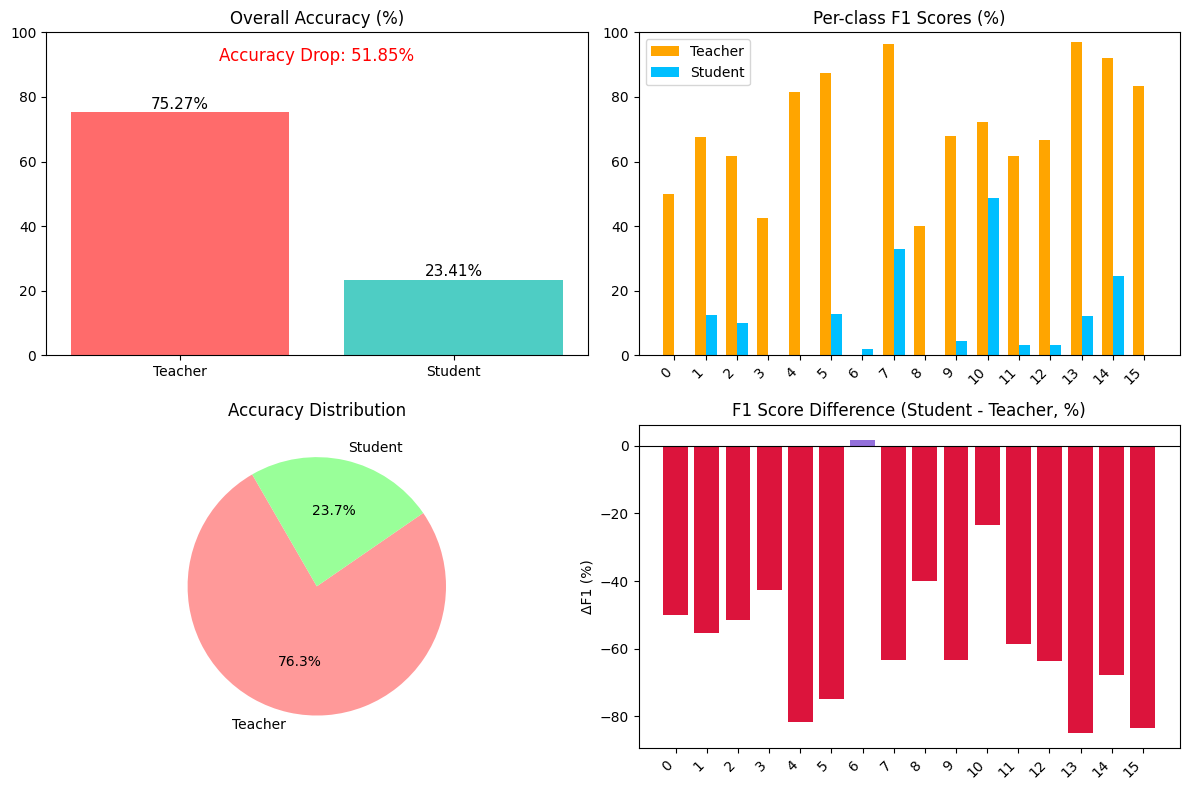

Teacher Accuracy: 75.27%
Student Accuracy: 23.41%
Accuracy Drop in Student: 51.85%


In [248]:
# === Accuracy & F1 Comparison Visualization ===
from sklearn.metrics import accuracy_score, classification_report
import matplotlib.pyplot as plt
import numpy as np

# --- Compute metrics ---
teacher_acc = accuracy_score(teacher_labels, teacher_preds)
student_acc = accuracy_score(pruned_labels, pruned_preds)

# Accuracy drop in %
acc_drop = (teacher_acc - student_acc) * 100

# Per-class F1 scores
teacher_report = classification_report(teacher_labels, teacher_preds, output_dict=True, zero_division=0)
student_report = classification_report(pruned_labels, pruned_preds, output_dict=True, zero_division=0)

# Get class names (remove avg keys)
class_names = [c for c in teacher_report.keys() if c not in ["accuracy", "macro avg", "weighted avg"]]

teacher_f1 = [teacher_report[c]["f1-score"] for c in class_names]
student_f1 = [student_report[c]["f1-score"] for c in class_names]

# --- Visualization ---
fig, axs = plt.subplots(2, 2, figsize=(12, 8))

# 1. Overall Accuracy (percentage)
axs[0,0].bar(["Teacher", "Student"], [teacher_acc*100, student_acc*100],
             color=["#FF6B6B", "#4ECDC4"])
axs[0,0].set_ylim(0, 100)
axs[0,0].set_title("Overall Accuracy (%)")
for i, val in enumerate([teacher_acc, student_acc]):
    axs[0,0].text(i, val*100 + 1, f"{val*100:.2f}%", ha="center", fontsize=11)

axs[0,0].text(0.5, 90, f"Accuracy Drop: {acc_drop:.2f}%", 
              ha="center", va="bottom", fontsize=12, color="red")

# 2. Per-class F1 scores
x = np.arange(len(class_names))
width = 0.35
axs[0,1].bar(x - width/2, np.array(teacher_f1)*100, width, label="Teacher", color="#FFA500")
axs[0,1].bar(x + width/2, np.array(student_f1)*100, width, label="Student", color="#00BFFF")
axs[0,1].set_xticks(x)
axs[0,1].set_xticklabels(class_names, rotation=45, ha="right")
axs[0,1].set_ylim(0, 100)
axs[0,1].set_title("Per-class F1 Scores (%)")
axs[0,1].legend()

# 3. Accuracy Distribution Pie
axs[1,0].pie([teacher_acc, student_acc], labels=["Teacher", "Student"],
             autopct="%1.1f%%", colors=["#FF9999", "#99FF99"], startangle=120)
axs[1,0].set_title("Accuracy Distribution")

# 4. Difference per class (in %)
diff = (np.array(student_f1) - np.array(teacher_f1)) * 100
axs[1,1].bar(x, diff, color=["#9370DB" if d>=0 else "#DC143C" for d in diff])
axs[1,1].axhline(0, color="black", linewidth=0.8)
axs[1,1].set_xticks(x)
axs[1,1].set_xticklabels(class_names, rotation=45, ha="right")
axs[1,1].set_title("F1 Score Difference (Student - Teacher, %)")
axs[1,1].set_ylabel("ΔF1 (%)")

plt.tight_layout()
plt.savefig("accuracy_comparison.png", dpi=500)
plt.show()

print(f"Teacher Accuracy: {teacher_acc*100:.2f}%")
print(f"Student Accuracy: {student_acc*100:.2f}%")
print(f"Accuracy Drop in Student: {acc_drop:.2f}%")
